# Проект "Телекоммуникации"


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


<font size = 4> **Описание данных** </font>

Данные представлены в 4 таблицах:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

<font size = 4> **Описание услуг** </font>

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Описание остальных столбцов данных:
- BeginDate – дата начала пользования услугами;
- EndDate – дата окончания пользования услугами;
- Type – тип оплаты: ежемесячный, годовой и тд;
- PaperlessBilling – электронный платёжный документ;
- PaymentMethod – способ оплаты;
- MonthlyCharges – ежемесячные траты на услуги по договору;
- TotalCharges – всего потрачено денег на услуги;
- Dependents – наличие иждивенцев;
- Senior Citizen – наличие пенсионного статуса по возрасту;
- Partner – наличие супруга(и);
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


*Информация о договорах актуальна на 1 февраля 2020.*

<font size = 4> **Постановка задачи и целей** </font>

**Цель:** Обучить модель, определяющую с точностью более 85% желание клиента отказаться от услуг компании, чтобы не потерять его и своевременно предложить промокоды и специальные условия.

**План работы:**

1. Провести предобработку данных:
    - Выделить целевой признак;
    - Привести данные к правильному формату;
    - Изучить аномалии;
    - Заполнить пропуски;
    - Изучить корреляционные связи между факторами и целевым признаком;
    - Выделить новые признаки для обучения модели;
    - Избавиться от лишних признаков;
    - Подготовить данные, разбив выборку на обучающую и тестовую в отношении 3:1;
1. Обучить 3 модели и подобрать гиперпараметры:
    - Закодировать категориальные и численные признаки;
    - Подобрать лучшие параметры с помощью кросс-валиадции;
    - Обучить модель на лучших гиперпараметрах;
    - Выбрать наилучшую модель по AUC-ROC метрике (не менее 0.85).
1. Проверить лучшую модель на тестовой выборке:
    - Составить матрицу анализа ошибок; 
    - Оценить важность признаков; 
    - Оценить метрику AUC-ROC и Accuracy.
1. Составить отчёт.

## Исследовательский анализ данных

In [1]:
# Подключим все необходимые для исселдовательского анализа данных библиотеки:
import pandas as pd
import numpy as np
import re
import os
import phik

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
STATE = 3072023

# Поместим в переменные исследуемые таблицы:
    
contract1 = '/datasets/contract_new.csv'
personal1 = '/datasets/personal_new.csv'
internet1 = '/datasets/internet_new.csv'
phone1 = '/datasets/phone_new.csv'

contract2 = 'contract_new.csv'
personal2 = 'personal_new.csv'
internet2 = 'internet_new.csv'
phone2 = 'phone_new.csv'

index_col = 'customerID'

if os.path.exists(contract1):
    data_contract = pd.read_csv(contract1, index_col=index_col)
    data_personal = pd.read_csv(personal1, index_col=index_col)
    data_internet = pd.read_csv(internet1, index_col=index_col)
    data_phone = pd.read_csv(phone1, index_col=index_col)
elif os.path.exists(contract2):
    data_contract = pd.read_csv(contract2, index_col=index_col)
    data_personal = pd.read_csv(personal2, index_col=index_col)
    data_internet = pd.read_csv(internet2, index_col=index_col)
    data_phone = pd.read_csv(phone2, index_col=index_col)
else:
    print('Something is wrong')

In [3]:
# Напишем функцию, выводящую первые 5 строк таблицы и сводную информацию о ней:

def show_info (data):
    # Отобразиnmь 5 первых строк таблицы:
    display(data.head(5))
    print()
    # Вывести общую информацию таблицы:
    data.info()

In [4]:
# Применим функцию show_info ко всем имеющимся табилцам:

print('Информация по таблице contract:')
show_info(data_contract)
print('\nИнформация по таблице personal:')
show_info(data_personal)
print('\nИнформация по таблице internet:')
show_info(data_internet)
print('\nИнформация по таблице phone:')
show_info(data_phone)

Информация по таблице contract:


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB

Информация по таблице personal:


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB

Информация по таблице internet:


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB

Информация по таблице phone:


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Таблицы с клиентами, подключившими услуги интернет и телефонии имеют меньшее количество строк, чем таблица со всеми клиентами компании. Очевидно, не все клиенты компании используют оба вида услуг. 

Следующим шагом объединим все таблицу в одну, чтобы было удобнее работать с данными. Для этого воспользуемся общим признаком во всех таблицах - столбцом `customerID`:

In [5]:
# Создадим список, содержащий все имеющиеся таблицы:
data_frames = [data_contract, data_personal, data_internet, data_phone]

# Объединим их в переменной data:
data = reduce(lambda left,right: pd.merge(left, right, on=['customerID'], how='outer'), data_frames)

# Выгрузим из памяти начальные таблицы за ненадобностью:
del data_frames, data_contract, data_personal, data_internet, data_phone

# Выведем общую информацию по полученной таблице:
show_info(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null

В генеральной выборке большинство признаков бинарные. Есть столбцы с признаками категориальными и всего два количественных, представленных в столбцах `MonthlyCharges` и `TotalCharges`. 

Для корректного обучения модели необходимо предобработать данные, а именно:

1. Выделить целевой признак;
1. Привести названия столбцов к одному регистру (для удобства);
1. Привести данные в столбцах к правильному формату;
1. Заполнить пропуски;
1. Закодировать имеющиеся категориальные признаки (для простоты обучения модели);
1. Дополнить генеральную выборку новыми признаками, имеющими интерес при дальнейшем моделировании;
1. Оценить мультиколлинеарность признаков и убрать лишние;
1. Подготовить данные, разбив выборку на обучающую и тестовую.

Для изменения названия столбцов напишем пару функций, применим их на `data` и ознакомимся с результатом:

In [6]:
def camel_to_snake(column_name):
    # Используем регулярное выражение, чтобы разделить CamelCase на snake_case:
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    converted_name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
    return converted_name

def convert_column_names(df):
    new_columns = []
    for column in df.columns:
        converted_name = camel_to_snake(column)
        new_columns.append(converted_name)
    df.columns = new_columns
    return df

data = convert_column_names(data)
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Прежде чем изменять данные, стоит выделить целевой признак и вынести его в отдельный столбец `is_client`:

In [7]:
def client_outflow(enddate):
    if enddate == 'No':
        return 1
    else:
        return 0

data['is_client'] = data['end_date'].apply(client_outflow)
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


От столбца `total_charges` можно избавиться, так как для обучения модели гораздо важнее иметь информацию "сколько клиент платит в месяц", чем сумма платежей каждого клиента:

In [8]:
data.drop('total_charges', axis=1, inplace=True)
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


Чтобы привести к формату даты столбцы `begin_date` и `end_date` необходимо заполнить пропуски в `end_date` последней актуальной для наших данных датой - 01.02.2020, поскольку отсутствие конечной даты означает, что человек всё ещё является клиентом компании. Но сперва убедимся, что эта дата не встречается в выборке:

In [9]:
count = len(data[data['end_date'] == '2020-02-01'])
count

0

Первое февраля 2020 года не встречается в выборке. Продолжим намеченную операцию:

In [10]:
data['end_date'] = data['end_date'].replace('No', '2020-02-01')
# Выведем результат:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


Приведём к формату `datetime` столбцы `begin_date` и `end_date` и выведем результат:

In [11]:
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = pd.to_datetime(data['end_date'])

# Вывод типов данных столбцов после конвертации
print(data.dtypes)

begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiple_lines               object
is_client                     int64
dtype: object


Изучим пропуски в генеральной выборке: 

In [12]:
missing_values = data.isna().sum()
missing_values = missing_values[missing_values != 0]
missing_values

internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

С целью заполнения пропусков в генеральной выборке воспользуемся "заглушкой" `NotUsed` и заполним ею пустые ячейки:

In [13]:
data = data.fillna('NotUsed')
missing_values = data.isna().sum()
missing_values = missing_values[missing_values != 0]
display(missing_values)
del missing_values

Series([], dtype: int64)

Добавим в выборку столбец `was_client_for`, в котором отразим, сколько суток человек являлся потребителем услуг компании: 

In [14]:
data['was_client_for'] = (data['end_date'] - data['begin_date']).dt.days
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client,was_client_for
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NotUsed,1,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NotUsed,1,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,153


Следующим шагом предобработки будет удаление столбцов `begin_date` и `end_date`, поскольку они более не представляют ценности для обучения модели:

In [15]:
data.drop(['end_date', 'begin_date'], axis=1, inplace=True)
data.head()

,type,paperless_billing,payment_method,monthly_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client,was_client_for
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NotUsed,1,31
5575-GNVDE,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NotUsed,1,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,153


Последним этапом исследовательского анализа построим тепловую карту корреляции и определим, есть ли мультикорреляционные признаки:

In [16]:
data_for_matrix = data.copy()
data_for_matrix.drop(['is_client'],axis=1,inplace=True)

In [17]:
corr_matrix = data_for_matrix.phik_matrix(interval_cols=['monthly_charges', 'was_client_for'])

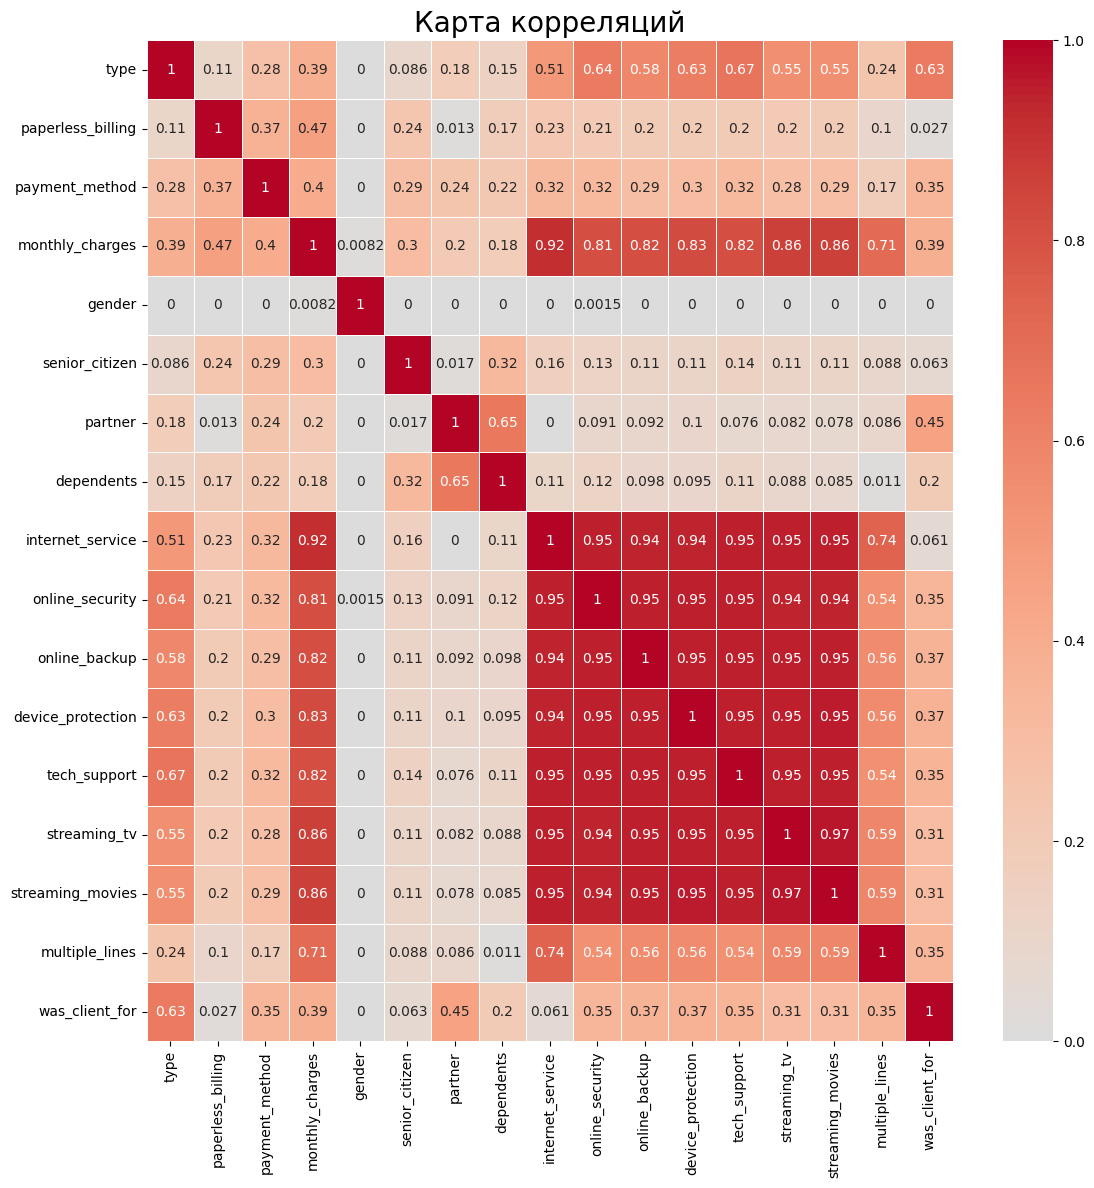

In [18]:
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax, center=0)
ax.set_title('Карта корреляций', fontsize=20)
plt.show()

На тепловой карте замечена высокая мультиколлинеарность между признаками, связанными с предосталвяемыми услугами компании. Добавим столбец категориальных признаков `is_interent_user`, где каждому пользователю назначим одну из трёх категорий:
- 0, если 'No' во всех мультиколлинеарных столбцах;
- 1, если есть хоть один 'Yes' в любом из мультиколлинеарных столбцов;
- 2, если есть 'NotUsed', но нет 'Yes'. 

In [19]:
def get_internet_user(row):
    if (row == 'Yes').any():
        return 1
    elif (row == 'No').all():
        return 0
    elif (row == 'NotUsed').any():
        return 2
    else:
        return print('Something went wrong')

cols = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
data['is_internet_user'] = data[cols].apply(get_internet_user, axis=1)

# Удаляем мультиколлинеарные столбцы
data = data.drop(cols, axis=1)
data = data.drop(['internet_service', 'monthly_charges'], axis=1)

### Вывод:

В ходе предобработки данных:
- Выедлен целевой признак `is_client`;
- Данные приведены к правильному формату;
- Устранены аномалии;
- Заполнены пропуски;
- Выделены новые признаки для обучения модели;
- Изучена мультиколинеарность между признаками - замечена высокая степень связи между признаками, отображающими услуги компании;
- Исключены лишние признаки.

## Обучение моделей машинного обучения
### Подготовка данных

Прежде, чем передать данные машине на обучение, следует:
- Проверить дисбаланс классов;
- Разбить выборку на обучающую и тестовую. 

Начнём с первого и выведем на экран отношение положительных классов (клиент остался в компании) и отрицательных (клиент ушёл).

In [21]:
count_0 = (data['is_client'] == 0).sum()
count_1 = (data['is_client'] == 1).sum()

ratio = count_0 / count_1

print(f"Соотношение нулей к единицам: {ratio:.2f}")

Соотношение нулей к единицам: 0.19


Соотношение классов 0.19 означает, что в столбце ‘is_client’ количество нулей примерно в 5 раз меньше, чем количество единиц. Это указывает на значительный дисбаланс классов в данных.

Такой дисбаланс может привести к тому, что модель машинного обучения будет плохо распознавать класс с меньшим количеством наблюдений (в данном случае - класс с меткой 0). К счастью, метрика оценки успешности нашей модели (ROC-AUC) нечувствительна к дисбалансу целевого класса.

Выделим категориальные и числовые признаки, разделим выборку на обучающую и тестовую в соотношении 1 к 3 и сразу убедимся, что пропорция верно соблюдена и мультиколлинеарность отсутствует:

In [22]:
X = data.drop('is_client', axis=1)
y = data['is_client']

# Определяем числовые и категориальные признаки
num_features = ['was_client_for']
cat_features = data.drop(['was_client_for', 'is_client'], axis=1).columns.tolist()

# разделяем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=STATE)

train_to_general = X_train.shape[0]/data.shape[0]*100
test_to_general = X_test.shape[0]/data.shape[0]*100

print(f"Обучающая выборка составляет {train_to_general:.2f}% от генеральной")
print(f"Тестовая выборка составляет {test_to_general:.2f}% от генеральной")

Обучающая выборка составляет 75.00% от генеральной
Тестовая выборка составляет 25.00% от генеральной


Выборки разделены корректно, можно переходить к обучению моделей. Для всех моделей будут перебраны гиперпараметры и оценена метрика ROC-AUC.

### CatBoostClassifier

In [23]:
# Создаем предобработчики для числовых и категориальных признаков
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')
cat_transformer_lr = OneHotEncoder(handle_unknown='error', drop='first')

# Создаем ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

preprocessor_catb = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features)],
    remainder='passthrough'
    )

preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer_lr, cat_features)
    ])

In [24]:
# Создаем pipeline для модели CatBoost
cat_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_catb),
    ('feature_selection', SelectFromModel(CatBoostClassifier(random_state=STATE, 
                                                             verbose=False, 
                                                             cat_features=[i for i in range(1,10)]
                                                            ), 
                                          threshold=0.05)),
    ('classifier', CatBoostClassifier(random_state=STATE, 
                                      verbose=False, 
                                      cat_features=[i for i in range(1,10)]
                                     )
    )
])

# Определяем параметры для gridSearch
cat_param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__learning_rate': [0.03, 0.1],
    'classifier__depth': [4, 6, 8],
    'classifier__l2_leaf_reg': [1, 3, 5]
}

cat_grid_search = GridSearchCV(cat_pipe, cat_param_grid, cv=5, error_score='raise', scoring='roc_auc', n_jobs=-1)
cat_grid_search.fit(X_train, y_train)

print(f'CatBoost лучшие параметры: {cat_grid_search.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid_search.best_score_}')

CatBoost лучшие параметры: {'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}
CatBoost лучшая оценка: 0.9025514010334031


### RandomForestClassifier

In [25]:
# Создаем pipeline для модели RandomForest
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=STATE), threshold=0.05)),
    ('classifier', RandomForestClassifier(random_state=STATE))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print(f'RandomForest лучшие параметры: {rf_grid_search.best_params_}')
print(f'RandomForest лучшая оценка: {rf_grid_search.best_score_}')

RandomForest лучшие параметры: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
RandomForest лучшая оценка: 0.8894427304780269


### LogisticRegression

In [26]:
# Создаем pipeline для модели LogisticRegression
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(random_state=STATE), threshold=0.05)),
    ('classifier', LogisticRegression(random_state=STATE))
])

lr_param_grid = {
    'classifier__C': [0.1, 1.0],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

print(f'LogisticRegression лучшие параметры: {lr_grid_search.best_params_}')
print(f'LogisticRegression лучшая оценка: {lr_grid_search.best_score_}')

LogisticRegression лучшие параметры: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LogisticRegression лучшая оценка: 0.7491424954240233


In [27]:
def fill_df(df, model_name, train_acc):
    df.loc[model_name] = [train_acc]

pivot_table = pd.DataFrame(index=['CatBoostRegression', 'RandomForestRegression', 'LogisticRegression'],
                  columns=['auc_roc, %'])

fill_df(pivot_table, 'CatBoostRegression', round(cat_grid_search.best_score_, 4))
fill_df(pivot_table, 'RandomForestRegression', round(rf_grid_search.best_score_, 4))
fill_df(pivot_table, 'LogisticRegression', round(lr_grid_search.best_score_, 4))
pivot_table['auc_roc, %'] = pivot_table['auc_roc, %']*100

# Вывод датафрейма
pivot_table

,"auc_roc, %"
CatBoostRegression,90.26
RandomForestRegression,88.94
LogisticRegression,74.91


По результатам оценки моделей на точность предсказаний наиболее удачным вариантом выбрана CatBoostRegression.

### Проверка модели на тестовой выборке

In [28]:
best_model = cat_grid_search.best_estimator_

best_model_pred = best_model.predict(X_test)
best_model_accuracy = accuracy_score(y_test, best_model_pred)

print(f'Точность на тестовой выборке: {best_model_accuracy:.4f}')
print(f'ROC-AUC лучшей модели: {cat_grid_search.best_score_:.4f}')

Точность на тестовой выборке: 0.9029
ROC-AUC лучшей модели: 0.9026


Модель показала 90% точность (accuracy). Эта метрика вычисляется отношением числа правильно классифицированных объектов к общему числу объектов. То есть наша модель в 9 из 10 случаев корректно предсказала, останется ли клиент в компании, или нет.

Полученная метрика ROC-AUC удовлетворяет условие и не превышает 0.95, что сказало бы об утечке целевого признака в данных и переобучении модели. Выведем матрицу ошибок и наиболее важные признаки для более детального интерпретирования результата этой метрики:

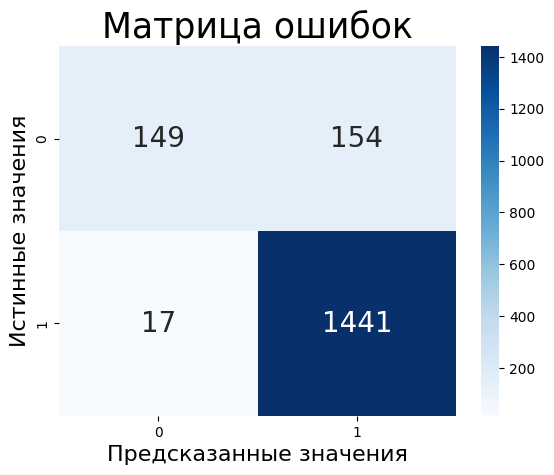

In [29]:
conf_matrix = confusion_matrix(y_test, best_model_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='Blues')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

Согласно тестовой выборке, из компании де-факто ушло 166 клиентов (сумма в столбце "предсказанные значения", 0), однако наша модель верно предсказала уход лишь 149 клиентов, а 17 предсказала обратное. Соответственно и для оставшихся с компанией клиентов (сумма в столбце "предсказанные значения", 1) - из 1595 клиентов, которые фактически остались в компании, модель ошиблась в отношении лишь 154 клиента, предсказав, что вскоре они откажутся от услуг фирмы, а 1441 клиентам модель предсказала дальнейшее сотрудничество с компанией.

Выведем график значимости признаков для обученной модели:

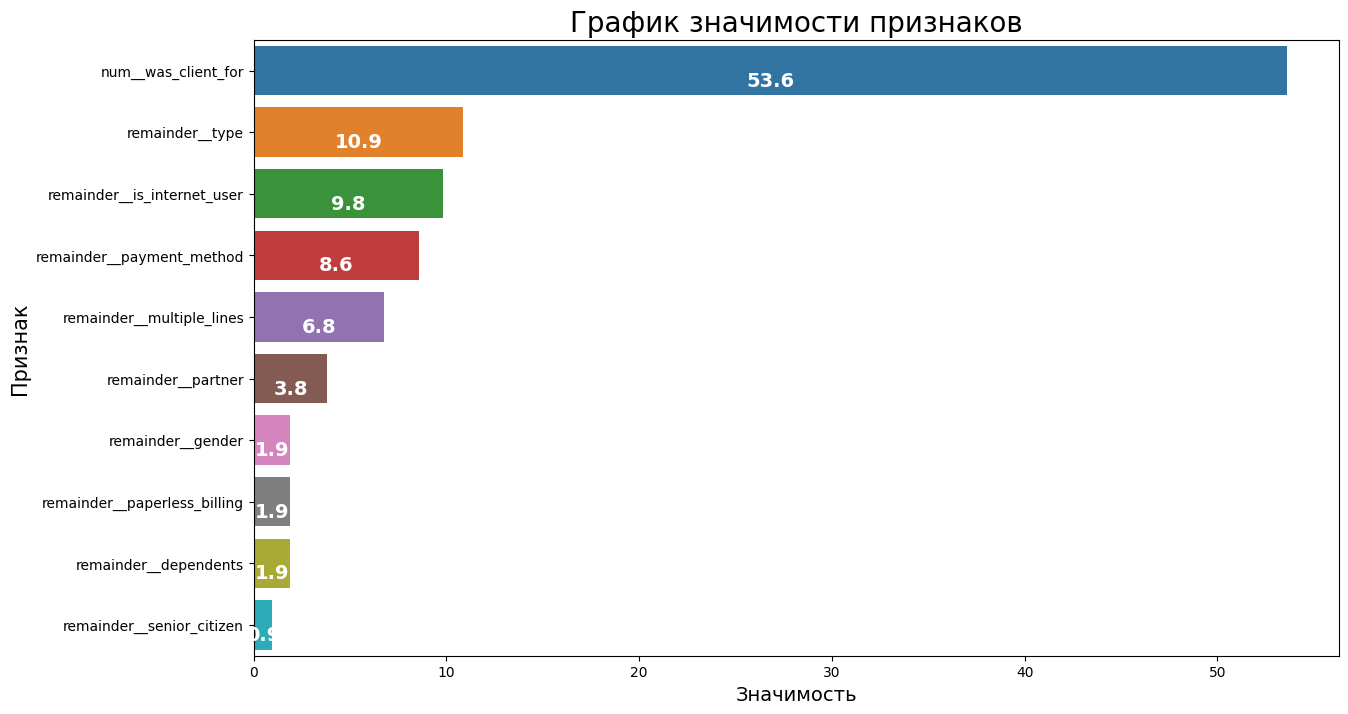

In [32]:
feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feature_importances = pd.DataFrame({'Признак': feature_names, 'Значимость': feature_importances}).sort_values(by='Значимость', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Значимость', y='Признак', data=feature_importances, orient='h')
ax.set_xlabel('Значимость', fontsize=14)
ax.set_ylabel('Признак', fontsize=15)
ax.set_title('График значимости признаков', fontsize=20)
for i, v in enumerate(feature_importances['Значимость']):
     ax.text(v/2, i + .25, str(round(v, 1)), color='white', fontweight='bold', ha='center', fontsize=14)
plt.show()

Самым значимым признаком оказалось:
- Количество проведённых клиентом дней с компанией; 
- Тип оплаты клиента за услуги компании;
- Факт использования клиента услугами "интернет".


Наименее важными признаками оказались:
- Наличие у клиента пенсионного статуса;
- Наличие иждивенцев;
- Электронный платёжный документ.

В основной части работы были обучены три модели и оценены их результаты работы метрикой AUC-ROC:

- CatBoostRegression - 90.26 %;
- RandomForestRegression - 88.94 %;
- LogisticRegression - 74.91 %.

Для обучения на тестовой выборке была выбрана модель CatBoostRegression. Согласно матрице ошибок, из 1761 предсказаний, модель не ошиблась в 1577, что и обеспечило метрику Auc-ROC эквивалентную 0.89, что значит, что случайное предсказание модели в отношении клиента с вероятность 89% будет верно - уйдёт он, или останется. Поставленная задача выполнена.

## Отчёт

**Цель:** Обучить модель, определяющую с точностью более 85% желание клиента отказаться от услуг компании, чтобы не потерять его и своевременно предложить промокоды и специальные условия.

**План работы:**

1. Провести предобработку данных:
    - Выделить целевой признак;
    - Привести данные к правильному формату;
    - Изучить аномалии;
    - Заполнить пропуски;
    - Изучить корреляционные связи между факторами и целевым признаком;
    - Выделить новые признаки для обучения модели;
    - Избавиться от лишних признаков;
    - Подготовить данные, разбив выборку на обучающую и тестовую в отношении 3:1;
1. Обучить 3 модели и подобрать гиперпараметры:
    - Закодировать категориальные и численные признаки;
    - Подобрать лучшие параметры с помощью кросс-валиадции;
    - Обучить модель на лучших гиперпараметрах;
    - Выбрать наилучшую модель по AUC-ROC метрике (не менее 0.85).
1. Проверить лучшую модель на тестовой выборке:
    - Составить матрицу анализа ошибок; 
    - Оценить важность признаков; 
    - Оценить метрику AUC-ROC и Accuracy.
1. Составить отчёт.

В ходе выполнения работы план был полностью выполнен:

1. Этап предобработки:
    - Целевой признак выделен в столбец `is_client`. Если у клиента отсутствовала дата окончания контракта - ему присваивалась 1, в обратном случае - 2;
    - Данные приведены к нужным форматам. Чтобы привести к формату "даты" столбец с датой окончания контракта, заменили значение "No" на последнюю актуальную для выборки дату - 01.02.2020;
    - Замечено аномальное значение в столбце `total_charges` - заместо суммы у пользователей, заключивших контракт 01.02.2020 был указан пробел. Поскольку сумма всех затрат клиента на услуги компании менее значимы, чем ежемесячные траты (отражающие пакет услгу клиента), было решено исключить столбец `total_charges` из выборки;
    - Пропуски замечены только в столбцах, связанных с предоставляемыми услугами "инетрнет" и заменены заглушкой `NotUsed`, чтобы не искажать логику выборки;
    - При изучении тесноты связей факторов обнаружена чрезвыйчайно высокая взаимосвязь уже упомянутых данных, связанных с предоставлением услуг "интернет". Пришлось заменить столбцы 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies' одним категориальным - `is_internet_user`, где 0 получили клиенты, не пользующиеся ни одной услгуой из пакета "инернет", 1 - пользующиеся хотя бы одной и 2, если клиент явно не пользовался услугами, но и имел заглушку `NotUsed`. **Однако и это не помогло избавиться от проблемы, т.к. осталась высокая теснота связи между вновь образованного признака и столбца `monthly_charges`. В качестве решения проблемы, последний был исключён из выболрки.**
    - В качестве нового признака для обучения модели была выделена разница в сутках между днём заключения и расторжения контракта, выраженная в столбце `was_client_for`.
    - Из выборки были исключены столбцы с датами и типом подключения пользователя к интернету, поскольку они не представляют ценности для обучения модели;
    - Выборка разбита на обучающую и тестовую. В них вошли следующие признаки:
    
                1. type – тип оплаты: ежемесячный, годовой и тд;
                2. paperless_billing – электронный платёжный документ;
                3. payment_method – способ оплаты;
                4. gender – пол клиента;
                5. senior_citizen – наличие пенсионного статуса по возрасту;
                6. partner – наличие супруга(и);
                7. dependents – наличие иждивенцев;
                8. multiple_lines – наличие возможности ведения параллельных линий во время звонка;
                9. is_internet_user – посльзуется ли клиент суб-услугами, связанными с предоставлением интернета;
                10. was_client_for – сколько дней клиент оставался с компанией;
                11. is_client – целевой признак. Продолжает ли клиент платить за услуги компании, или нет.


2. Этап обучения моделей:
    - Выбраны три модели для машинного обучения:
        - CatBoostRegression;
        - RandomForestRegression;
        - LogisticRegression.
    - Каждая модель обучена на закодированных признаках: численные признаки масштабированны с помощью `StandardScaler`, а категориальные закодированны, используя `OneHotEncoder`. 
    - Для каждой модели были отобраны наиболее значимые признаки с помощью `SelectFromModel`;
    - Для каждой модели выбраны лучшие гиперпараметры с помощью кросс-валидации, обеспечиывающие бОльшую точность предсказаний;
    - Результаты работы модели были оценены метрикой `AUC-ROC` и выбрана одна, **`CatBoostRegression`**, для работы с тестовыми данными;
    
    
Ниже представлены полученные гиперпараметры обученных моделей и их метрики качества предсказаний:

In [33]:
print(f'Лучшие гиперпараметры CatBoost: {cat_grid_search.best_params_}')
print()
print(f'Лучшие гиперпараметры RandomForest: {rf_grid_search.best_params_}')
print()
print(f'Лучшие гиперпараметры LogisticRegression: {lr_grid_search.best_params_}')

pivot_table

Лучшие гиперпараметры CatBoost: {'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}

Лучшие гиперпараметры RandomForest: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}

Лучшие гиперпараметры LogisticRegression: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


,"auc_roc, %"
CatBoostRegression,90.26
RandomForestRegression,88.94
LogisticRegression,74.91


Используя полученные гиперпараметры, модель `CatBoost` была обучена на тестовой выборке и сделала предсказание уходящих и остающихся с компанией клиентов. Результат оценивался не только метрикой `AUC-ROC`, но и `accuracy_score`. Получены следующие метрики:

    - Точность на тестовой выборке: 0.90
    - ROC-AUC лучшей модели: 0.90
    
То есть, модель показала 90% точность (`accuracy_score`). Эта метрика вычисляется отношением числа правильно классифицированных объектов к общему числу объектов. То есть наша модель в 9 из 10 случаев корректно предсказала, останется ли клиент в компании, или нет.

Полученная метрика ROC-AUC удовлетворяет условие и не превышает 0.95, что сказало бы об утечке целевого признака в данных и переобучении модели. Выведем матрицу ошибок и наиболее важные признаки для более детального интерпретирования результата этой метрики:

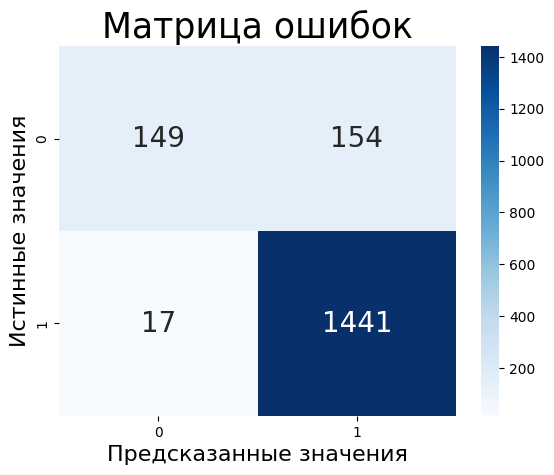

In [34]:
sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='Blues')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

Согласно тестовой выборке, из компании де-факто ушло 166 клиентов (сумма в столбце "предсказанные значения", 0), однако наша модель верно предсказала уход лишь 149 клиентов, а 17 предсказала обратное. Соответственно и для оставшихся с компанией клиентов (сумма в столбце "предсказанные значения", 1) - из 1595 клиентов, которые фактически остались в компании, модель ошиблась в отношении лишь 154 клиента, предсказав, что вскоре они откажутся от услуг фирмы, а 1441 клиентам модель предсказала дальнейшее сотрудничество с компанией.

Выведем график значимости признаков для обученной модели:

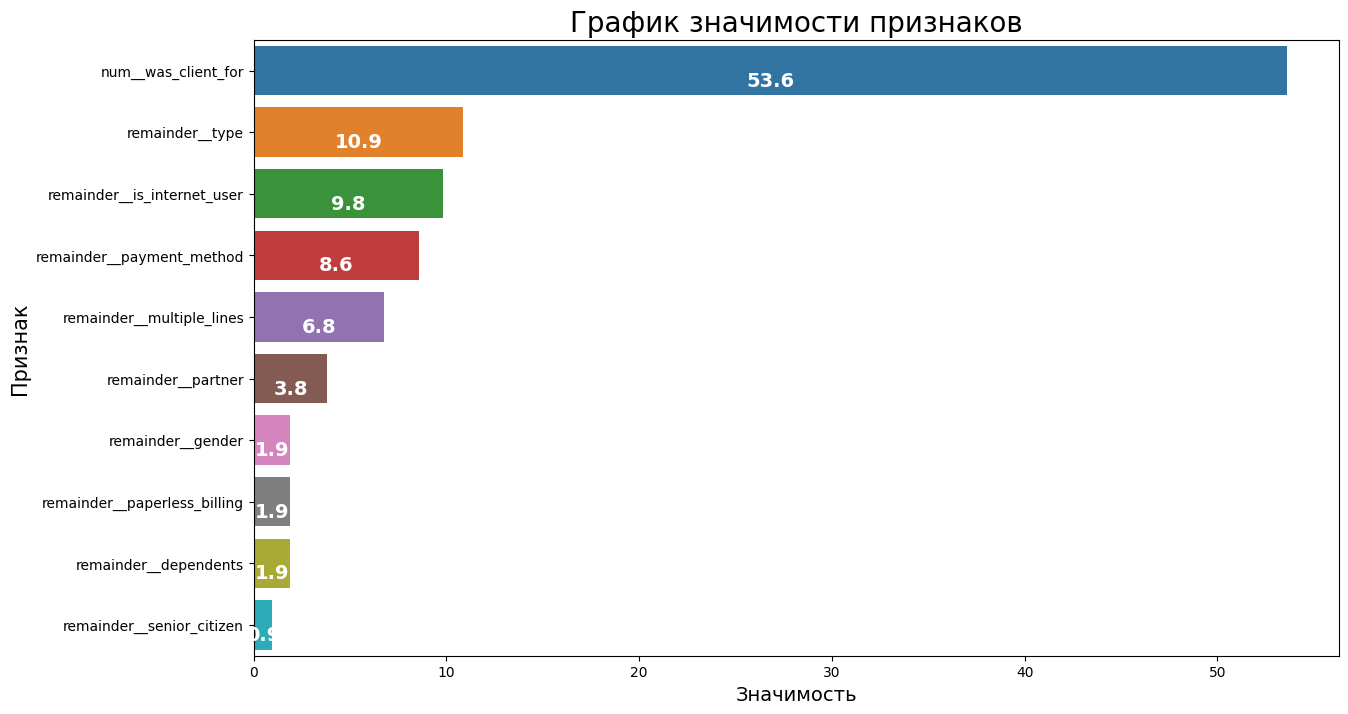

In [35]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Значимость', y='Признак', data=feature_importances, orient='h')
ax.set_xlabel('Значимость', fontsize=14)
ax.set_ylabel('Признак', fontsize=15)
ax.set_title('График значимости признаков', fontsize=20)
for i, v in enumerate(feature_importances['Значимость']):
     ax.text(v/2, i + .25, str(round(v, 1)), color='white', fontweight='bold', ha='center', fontsize=14)
plt.show()

Самым значимым признаком оказалось количество проведённых клиентом дней в компании. Немаловажными факторами являются Тип оплаты клиента за услуги компании и факт использования клиента услугами "интернет". Наименее важными признаками оказались Наличие у клиента пенсионного статуса, иждивенцев и электронный платёжный документ.

**Вывод**
В ходе работы модель `CatBoost` была обучена на предобработанных данных и лучших гиперпараметрах. В результате получены метрики точности и `AUC-ROC`, эквивалентые 90% и 90% соответственно. Результатом работы модели является высокоточное определние желания клиента компании отказаться от пользования её услугами. Таким образом, в 9 из 10 случаев возможно своевременно предложить сомневающемуся клиенту промокоды и специальные условия, чтобы предотвратить клиентооток. 